In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM

In [2]:
df_genaudit  = pd.read_csv('/home/ramprasad.sa/probing_summarization_factuality/datasets/Genaudit_annotations.csv')
df_genaudit['docid_processed'] = [row['id'].split('#')[-1] for idx, row in df_genaudit.iterrows()]
df_genaudit.head()


# shortlist_ids = 'Cynthia Lamanda#XSUM-19389161:mistral7b-ul2'
# # df = df_genaudit[df_genaudit['model'] == 'llama7b']
# # df = df[df['origin'] == 'REDDIT']
# # df[~df['annotated_spans'].isnull()]
# df_genaudit[df_genaudit['id'].isin([shortlist_ids])]
df_genaudit

,Unnamed: 0,id,source,summary,annotated_spans,model,origin,docid_processed
0,0,Rachel Usher#REDDIT-83:flanul2-ul2,both me and my girlfriend participate in winte...,I waited outside the locker rooms for my girlf...,nobody,flanul2,REDDIT,REDDIT-83:flanul2-ul2
1,1,Rachel Usher#REDDIT-83:llama70b-ul2,both me and my girlfriend participate in winte...,A high school student was waiting for his girl...,NaN,llama70b,REDDIT,REDDIT-83:llama70b-ul2
2,2,Rachel Usher#REDDIT-83:falcon7b-ul2,both me and my girlfriend participate in winte...,The protagonist is concerned about a potential...,concerned about a potential delay in meeting<s...,falcon7b,REDDIT,REDDIT-83:falcon7b-ul2
3,3,Rachel Usher#REDDIT-83:llama7b-ul2,both me and my girlfriend participate in winte...,The writer and their girlfriend are both invol...,is late<sep>bus and doesn't realize that their...,llama7b,REDDIT,REDDIT-83:llama7b-ul2
4,4,Rachel Usher#REDDIT-83:mistral7b-ul2,both me and my girlfriend participate in winte...,The document describes the experience of a hig...,participates<sep>with their girlfriend<sep>ends,mistral7b,REDDIT,REDDIT-83:mistral7b-ul2
...,...,...,...,...,...,...,...,...
697,697,Rachel Usher#XSUM-39387550:llama7b-ul2,US President Donald Trump has withdrawn his he...,US President Donald Trump's healthcare bill ha...,NaN,llama7b,XSUM,XSUM-39387550:llama7b-ul2
698,698,Rachel Usher#XSUM-39387550:falcon7b-ul2,US President Donald Trump has withdrawn his he...,US President Donald Trump and House Speaker Pa...,With just days to go until the US health care ...,falcon7b,XSUM,XSUM-39387550:falcon7b-ul2
699,699,Rachel Usher#XSUM-39387550:gpt4-ul2,US President Donald Trump has withdrawn his he...,US President Donald Trump has withdrawn his he...,due to its severe cuts to health coverage,gpt4,XSUM,XSUM-39387550:gpt4-ul2
700,700,Rachel Usher#XSUM-39387550:geminipro-ul2,US President Donald Trump has withdrawn his he...,US President Donald Trump withdrew his healthc...,NaN,geminipro,XSUM,XSUM-39387550:geminipro-ul2


In [3]:
model_path = {'mistral7b': 'mistralai/Mistral-7B-Instruct-v0.1',
             'falcon7b': 'tiiuae/falcon-7b-instruct',
              'llama7b': '/work/frink/models/llama_2_7b_chat_hf',
             'flanul2': 'google/flan-ul2'}

def load_tokenizer(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_path[model_name],
                                         cache_dir = '/scratch/ramprasad.sa/huggingface_models')
    return tokenizer

def refine_df(df_path):
    df = pd.read_csv(df_path)
    #### since teacher forcing, make sure to only use rows where predicted is same as prev generated
    df['target_token_id'] = [eval(row['target_token'].split('_')[-1]) for idx, row in df.iterrows()]
    df = df[df['target_token_id'] == df['pred_token_layer32']]
    return df

def read_model_probabilities_df(model_name, origin):
    data_path = f'/scratch/ramprasad.sa/probing_summarization_factuality/metric_scores/Genaudit/layer_wise_uncertainty_{model_name}_{origin}_document_context.csv'
    df_model = refine_df(data_path)
    tokenizer = load_tokenizer(model_name)
    df_model['model'] = [model_name] * len(df_model)
    return tokenizer, df_model

falcon_tokenizer, df_falcon_xsum = read_model_probabilities_df('falcon7b', 'XSUM')
llama_tokenizer, df_llama_xsum = read_model_probabilities_df('llama7b', 'XSUM')
mistral_tokenizer, df_mistral_xsum = read_model_probabilities_df('mistral7b', 'XSUM')
print(len(set(df_falcon_xsum['docid'])), len(set(df_llama_xsum['docid'])), len(set(df_mistral_xsum['docid'])))


mistral_tokenizer, df_mistral_acibench = read_model_probabilities_df('mistral7b', 'ACIBENCH')
falcon_tokenizer, df_falcon_acibench = read_model_probabilities_df('falcon7b', 'ACIBENCH')
llama_tokenizer, df_llama_acibench = read_model_probabilities_df('llama7b', 'ACIBENCH')

mistral_tokenizer, df_mistral_reddit = read_model_probabilities_df('mistral7b', 'REDDIT')
falcon_tokenizer, df_falcon_reddit = read_model_probabilities_df('falcon7b', 'REDDIT')
llama_tokenizer, df_llama_reddit = read_model_probabilities_df('llama7b', 'REDDIT')
print(len(set(df_mistral_reddit['docid'])), len(set(df_falcon_reddit['docid'])), len(set(df_llama_reddit['docid'])))

/home/ramprasad.sa/.conda/envs/probe/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/ramprasad.sa/.conda/envs/probe/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


30 30 30


/home/ramprasad.sa/.conda/envs/probe/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/ramprasad.sa/.conda/envs/probe/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/ramprasad.sa/.conda/envs/probe/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/ramprasad.sa/.conda/envs/probe/lib/python3.8/site-packages/huggingf

30 26 30


In [4]:
df_all_models_xsum = pd.concat([df_falcon_xsum, df_llama_xsum, df_mistral_xsum])
df_all_models_acibench = pd.concat([df_falcon_acibench, df_llama_acibench, df_mistral_acibench])
df_all_models_reddit = pd.concat([df_falcon_reddit, df_llama_reddit, df_mistral_reddit])

print(len(df_all_models_xsum))
df_all_models_acibench.head()
df_all_models = pd.concat([df_all_models_xsum, df_all_models_acibench, df_all_models_reddit])
docids = list(df_all_models['docid'].values)
docids = [each.split('#')[-1].split('-')[0] for each in docids]
df_all_models['origin'] = docids
df_all_models.head()

7656


/tmp/ipykernel_28906/274592062.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all_models['origin'] = docids


,Unnamed: 0,target_token,label,prev_hidden_state_sim_layer1,prev_hidden_state_sim_layer2,prev_hidden_state_sim_layer3,prev_hidden_state_sim_layer4,prev_hidden_state_sim_layer5,prev_hidden_state_sim_layer6,prev_hidden_state_sim_layer7,...,entropy_layer32,pred_prob_layer32,pred_token_layer32,target_prob_layer32,top3_predicted_probs_layer32,top3_predicted_tokens_layer32,docid,target_token_id,model,origin
1,0,f5e3fd93-4a51-41d1-bbee-95df37e62e07_3787,0,0.087404,0.902840,0.893597,0.929759,0.942955,0.880105,0.896535,...,0.032241,0.996724,3787,0.996724,"[0.9967244267463684, 0.001467414665967226, 0.0...","[3787, 13384, 302]",Cynthia Lamanda#XSUM-19389161:falcon7b-ul2,3787,falcon7b,XSUM
2,0,13311b7f-35ef-41e1-9ab0-a44486b3eae8_42402,0,0.099551,0.869240,0.945129,0.919445,0.949189,0.895772,0.914660,...,0.007364,0.999346,42402,0.999346,"[0.9993461966514587, 0.00038860522909089923, 5...","[42402, 1615, 85]",Cynthia Lamanda#XSUM-19389161:falcon7b-ul2,42402,falcon7b,XSUM
3,0,fe7ef2d9-6153-49a3-bd33-bc5014f8a1b4_1135,0,0.093394,0.833900,0.868841,0.864377,0.937902,0.926948,0.926052,...,0.006457,0.999557,1135,0.999557,"[0.9995569586753845, 4.4483716919785365e-05, 2...","[1135, 13384, 3081]",Cynthia Lamanda#XSUM-19389161:falcon7b-ul2,1135,falcon7b,XSUM
4,0,c27700b2-52f7-4846-9624-81371547692e_4497,0,0.054801,0.820559,0.903625,0.910642,0.937008,0.837402,0.905605,...,0.169321,0.987571,4497,0.987571,"[0.9875713586807251, 0.0006436973344534636, 0....","[4497, 286, 7508]",Cynthia Lamanda#XSUM-19389161:falcon7b-ul2,4497,falcon7b,XSUM
5,0,ac627bdb-0c54-422f-b174-9ca6363f610b_13384,0,0.121113,0.766579,0.750057,0.858033,0.901822,0.876636,0.918694,...,0.005929,0.999612,13384,0.999612,"[0.9996116757392883, 4.5011060137767345e-05, 3...","[13384, 16789, 42451]",Cynthia Lamanda#XSUM-19389161:falcon7b-ul2,13384,falcon7b,XSUM


In [5]:
set(df_all_models['origin'].values)

{'ACIBENCH', 'REDDIT', 'XSUM'}

In [6]:
set(df_all_models[df_all_models['model'] == 'mistral7b']['origin'].values)

{'ACIBENCH', 'REDDIT', 'XSUM'}

In [7]:
from random import sample 
import torch
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def get_sample_doc(model,
                   origin,
                   tokenizer):
    df_model_origin = df_all_models[(df_all_models['model'] == model) & (df_all_models['origin'] == origin)]
    ### make sure to include nonfactual 
    df_model_origin_nonfactual = df_model_origin[df_model_origin['label'] == 1]
    sample_doc = sample(list(set(df_model_origin_nonfactual['docid'])), 1)

    df_sample_doc = df_model_origin[df_model_origin['docid'] == sample_doc[0]]
    nonfactual_idx_vals = [idx for idx, lab in enumerate(df_sample_doc['label'].values) if lab == 1]
    print('SUMMARY', tokenizer.decode(df_sample_doc['pred_token_layer32']))
    return df_sample_doc, nonfactual_idx_vals

def make_heatmap_plot_data(df_sample_doc,
                      start_idx, 
                     end_idx,
                     num_layers = 32,
                     ranked_pred = False):
    sample_data = {
    'token_name': [],
    }

    sample_data_predictions = {}

    for layer_num in range(2,num_layers, 2):
        sample_data[f'layer_{layer_num}'] = []
        sample_data_predictions[f'layer_{layer_num}'] = []

    row_counter = 0
    for idx, row in df_sample_doc.iterrows():
        token = tokenizer.decode(row['pred_token_layer32'])
        label = row['label']
        # print(token, label)
        if row_counter >= start_idx and row_counter <= end_idx :
            label_str = 'F' if label == 0 else 'NF'
            sample_data['token_name'] += [f'{row_counter + 1}) {token} ({label_str})']
            row_jsds = [row[column] for column in row.keys() if 'jsd' in column]
            row_jsds = F.softmax(torch.tensor(row_jsds), dim = -1)
            row_label = row['label']
            row_label = 'factual' if row_label == 0 else 'non_factual'

            final_layer_prediction = row[f'pred_token_layer32']
            final_layer_prediction_str = tokenizer.decode(final_layer_prediction)
            for layer_num in range(2, num_layers, 2):
                top_layer_tokens = eval(row[f'top3_predicted_tokens_layer{layer_num}'])
                layer_prediction = row[f'pred_token_layer{layer_num}']
                layer_prediction_str = tokenizer.decode(layer_prediction)

                rank = -1
                if final_layer_prediction in top_layer_tokens:
                    # print(row[f'pred_token_layer{layer_num}'], top_layer_tokens)
                    rank = top_layer_tokens.index(final_layer_prediction) + 1


                final_ranked = f'{final_layer_prediction_str}-{rank}' if rank > -1 else 'NF'
                final_ranked = ', '.join([tokenizer.decode(each) for each in top_layer_tokens])
                jsd_layer = row[f'jsd_layer{layer_num}']
                sample_data[f'layer_{layer_num}'] += [row_jsds[layer_num - 1].item() ]
                if ranked_pred:
                    sample_data_predictions[f'layer_{layer_num}'] += [f'{final_ranked}']
                else:
                    sample_data_predictions[f'layer_{layer_num}'] += [f'{layer_prediction_str}']
                

        row_counter += 1
    # print({k : len(v) for k , v in sample_data_predictions.items()})
    sample_data = pd.DataFrame(sample_data)
    sample_data.set_index('token_name', inplace=True)
    sample_data_predictions = pd.DataFrame(sample_data_predictions)
    return sample_data.transpose(), sample_data_predictions.transpose()
        



# Sample DataFrame (replace this with your actual DataFrame)

def plot_heatmap(sample_data,
                 sample_data_predictions,
                 fig_width = 50,
                 fig_height= 9,
                filename= None):
    # Create a heatmap
    plt.figure(figsize=(fig_width, fig_height))
    sns.heatmap(sample_data, annot=False, cmap=sns.color_palette("BuPu", as_cmap=True))
    for i in range(len(sample_data.index)):
        for j in range(len(sample_data.columns)):
            plt.text(j + 0.5, i + 0.5, str(sample_data_predictions.iloc[i, j]), horizontalalignment='center', fontsize = 15, verticalalignment='center')
    plt.xticks(fontsize=18,rotation = 45)
    plt.yticks(fontsize=18)
    plt.title('Layer-wise Token Heatmap')
    plt.xlabel('Token Names')
    plt.ylabel('Layers')
    if filename:
        plt.savefig(f'{filename}.pdf')
    plt.show()
    return


In [8]:
mistral_tokenizer('_ _')
# mistral_tokenizer.decode([583, 583])

{'input_ids': [1, 583, 583], 'attention_mask': [1, 1, 1]}

In [24]:
#####plot difference in JSD for faithful and unfaithful tokens 
#### plot predictions by different layers 


model = 'mistral7b'
origin = 'XSUM'
tokenizer = mistral_tokenizer

df_sample_doc, nonfactual_idx_vals = get_sample_doc(model,
               origin,
               tokenizer)
# df_model_origin_nonfactual
print(nonfactual_idx_vals)




SUMMARY Bollywood director Sanjay Leela Bhansali to make a film on Olympics bronze medallist boxer MC Mary Koms life Kom herself the film as an inspiration to womenansali who has been planning the film for a year, impressed Mary Kom's and courage and yet decided on who will play her role The film is expected to the gap between people from the Indian mainland and those from the north-eastern states
[29, 30]


In [25]:
df_sample_doc

,Unnamed: 0,target_token,label,prev_hidden_state_sim_layer1,prev_hidden_state_sim_layer2,prev_hidden_state_sim_layer3,prev_hidden_state_sim_layer4,prev_hidden_state_sim_layer5,prev_hidden_state_sim_layer6,prev_hidden_state_sim_layer7,...,entropy_layer32,pred_prob_layer32,pred_token_layer32,target_prob_layer32,top3_predicted_probs_layer32,top3_predicted_tokens_layer32,docid,target_token_id,model,origin
0,0,92346e3b-e994-49bd-a81d-e7175d3aaf79_10823,0,0.571613,0.716998,0.773641,0.783539,0.897570,0.868688,0.884355,...,2.040002,0.352867,10823,0.352867,"[0.35286739468574524, 0.2680160701274872, 0.12...","[10823, 6735, 10598]",Cynthia Lamanda#XSUM-19389161:mistral7b-ul2,10823,mistral7b,XSUM
1,0,b522ed1c-0f84-4cee-9be7-a2a09bb73043_346,0,0.632406,0.818875,0.831130,0.885798,0.907975,0.924197,0.899672,...,0.000047,0.999997,346,0.999997,"[0.9999969005584717, 1.9940828224207507e-06, 5...","[346, 2, 28724]",Cynthia Lamanda#XSUM-19389161:mistral7b-ul2,346,mistral7b,XSUM
2,0,a294d73f-686b-436e-a91a-af5b34439b70_4871,0,0.365882,0.640151,0.765453,0.837453,0.896797,0.904630,0.915212,...,0.000788,0.999931,4871,0.999931,"[0.9999309778213501, 5.7942910643760115e-05, 7...","[4871, 2, 809]",Cynthia Lamanda#XSUM-19389161:mistral7b-ul2,4871,mistral7b,XSUM
3,0,a2d4ed5c-8073-4392-a8dc-ab6ec80f0a6a_6859,0,0.734975,0.540056,0.804692,0.855663,0.915697,0.904315,0.906244,...,0.202970,0.964888,6859,0.964888,"[0.9648875594139099, 0.019548581913113594, 0.0...","[6859, 2966, 9298]",Cynthia Lamanda#XSUM-19389161:mistral7b-ul2,6859,mistral7b,XSUM
4,0,f38b147c-67d1-4753-940a-5d3eaf42f7ec_3652,0,0.691200,0.831951,0.790813,0.847683,0.902268,0.887685,0.890043,...,0.039041,0.995023,3652,0.995023,"[0.9950234889984131, 0.003187327180057764, 0.0...","[3652, 2, 28725]",Cynthia Lamanda#XSUM-19389161:mistral7b-ul2,3652,mistral7b,XSUM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,0,44099d62-bc63-4041-8123-ba6f678effdb_6120,0,0.347681,0.774266,0.870727,0.863676,0.920932,0.898157,0.912671,...,0.420917,0.868697,6120,0.868697,"[0.8686965107917786, 0.12607116997241974, 0.00...","[6120, 27737, 3964]",Cynthia Lamanda#XSUM-19389161:mistral7b-ul2,6120,mistral7b,XSUM
104,0,9cfaf3f7-c842-446e-9d23-ef3ab1509104_28733,0,0.665519,0.867183,0.799656,0.887044,0.864485,0.910675,0.900399,...,0.007610,0.999199,28733,0.999199,"[0.9991994500160217, 0.00044292776146903634, 0...","[28733, 2, 16495]",Cynthia Lamanda#XSUM-19389161:mistral7b-ul2,28733,mistral7b,XSUM
105,0,ad1d28e7-d9e3-4a8f-a574-1247edc030df_28706,0,0.557982,0.721312,0.774510,0.916069,0.889805,0.921615,0.877440,...,0.008545,0.998998,28706,0.998998,"[0.99899822473526, 0.0008496522787027061, 8.58...","[28706, 24294, 2]",Cynthia Lamanda#XSUM-19389161:mistral7b-ul2,28706,mistral7b,XSUM
106,0,52072450-90e3-4aee-82a2-607c9a2663fa_10230,0,0.486953,0.717862,0.778858,0.855577,0.829645,0.855669,0.856266,...,0.000108,0.999992,10230,0.999992,"[0.9999922513961792, 5.9999010773026384e-06, 5...","[10230, 1993, 13827]",Cynthia Lamanda#XSUM-19389161:mistral7b-ul2,10230,mistral7b,XSUM


/tmp/ipykernel_28906/2876535670.py:101: UserWarning: Glyph 21320 (\N{CJK UNIFIED IDEOGRAPH-5348}) missing from current font.
  plt.savefig(f'{filename}.pdf')
/tmp/ipykernel_28906/2876535670.py:101: UserWarning: Glyph 2487 (\N{BENGALI LETTER SSA}) missing from current font.
  plt.savefig(f'{filename}.pdf')
/tmp/ipykernel_28906/2876535670.py:101: UserWarning: Matplotlib currently does not support Bengali natively.
  plt.savefig(f'{filename}.pdf')
/tmp/ipykernel_28906/2876535670.py:101: UserWarning: Glyph 59700 (\ue934) missing from current font.
  plt.savefig(f'{filename}.pdf')
/tmp/ipykernel_28906/2876535670.py:101: UserWarning: Glyph 38500 (\N{CJK UNIFIED IDEOGRAPH-9664}) missing from current font.
  plt.savefig(f'{filename}.pdf')
/tmp/ipykernel_28906/2876535670.py:101: UserWarning: Glyph 20303 (\N{CJK UNIFIED IDEOGRAPH-4F4F}) missing from current font.
  plt.savefig(f'{filename}.pdf')
/tmp/ipykernel_28906/2876535670.py:101: UserWarning: Glyph 21320 (\N{CJK UNIFIED IDEOGRAPH-5348}) mis

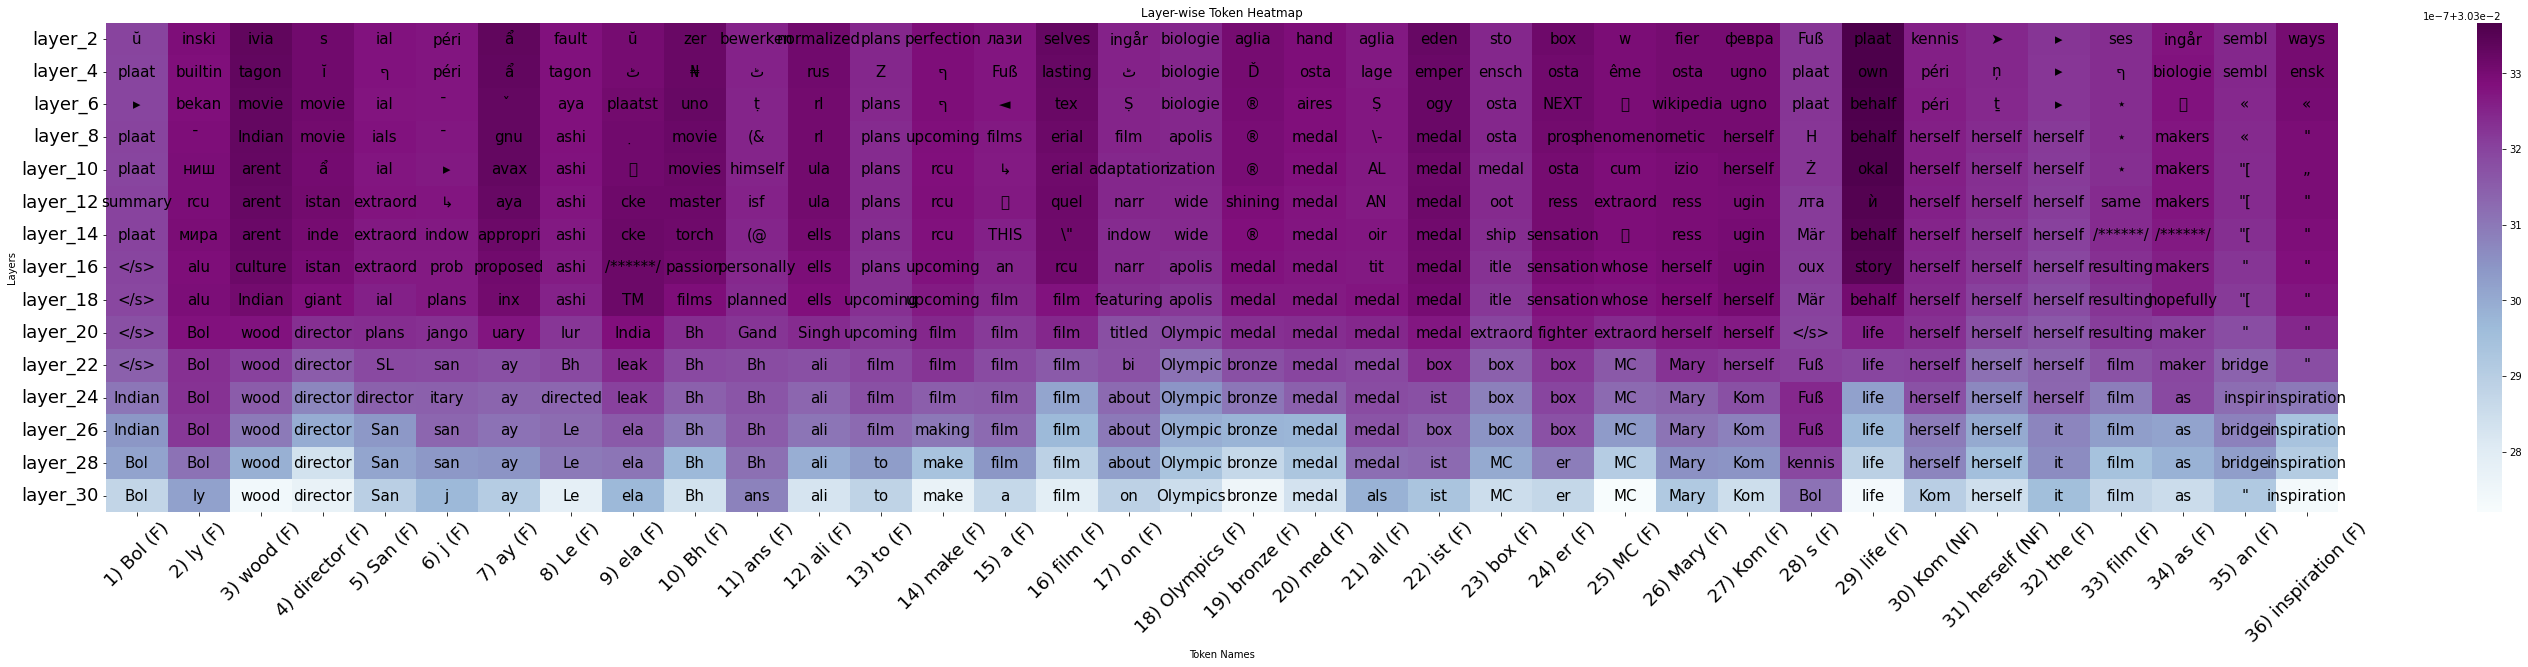

/tmp/ipykernel_28906/2876535670.py:101: UserWarning: Glyph 61607 (\uf0a7) missing from current font.
  plt.savefig(f'{filename}.pdf')
/tmp/ipykernel_28906/2876535670.py:101: UserWarning: Glyph 49569 (\N{HANGUL SYLLABLE SONG}) missing from current font.
  plt.savefig(f'{filename}.pdf')
/tmp/ipykernel_28906/2876535670.py:101: UserWarning: Glyph 59700 (\ue934) missing from current font.
  plt.savefig(f'{filename}.pdf')
/tmp/ipykernel_28906/2876535670.py:101: UserWarning: Glyph 12419 (\N{HIRAGANA LETTER SMALL YA}) missing from current font.
  plt.savefig(f'{filename}.pdf')
/tmp/ipykernel_28906/2876535670.py:101: UserWarning: Glyph 3625 (\N{THAI CHARACTER SO RUSI}) missing from current font.
  plt.savefig(f'{filename}.pdf')
/tmp/ipykernel_28906/2876535670.py:101: UserWarning: Glyph 22659 (\N{CJK UNIFIED IDEOGRAPH-5883}) missing from current font.
  plt.savefig(f'{filename}.pdf')
/tmp/ipykernel_28906/2876535670.py:101: UserWarning: Glyph 35874 (\N{CJK UNIFIED IDEOGRAPH-8C22}) missing from cu

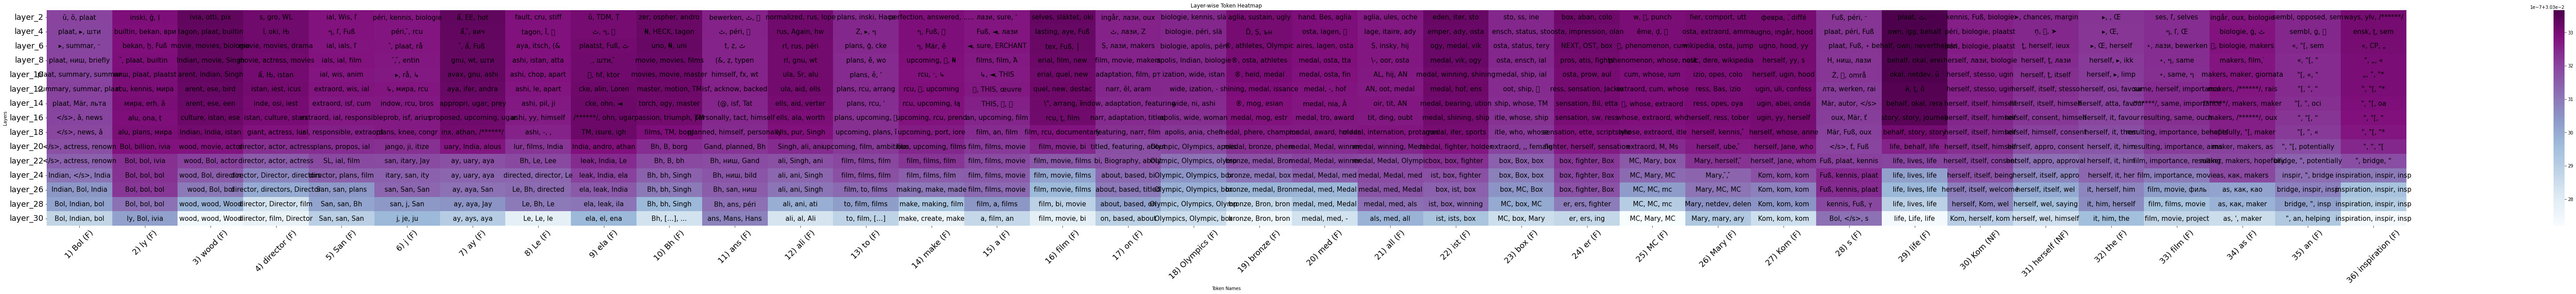

IndexError: index 0 is out of bounds for axis 0 with size 0

In [27]:
start_idx = 0
sample_data, sample_data_predictions= make_heatmap_plot_data(df_sample_doc,
                  start_idx = start_idx,
                  end_idx = start_idx + 35,
                  num_layers = 32,
                  ranked_pred = False)
plot_heatmap(sample_data,
             sample_data_predictions,
            filename = f'cherrypick_{origin}_{model}_pred_1')

sample_data_ranked, sample_data_predictions_ranked= make_heatmap_plot_data(df_sample_doc,
                  start_idx = start_idx,
                  end_idx = start_idx + 35,
                  num_layers = 32,
                  ranked_pred = True)
plot_heatmap(sample_data_ranked,
             sample_data_predictions_ranked,
             fig_width = 120,
            fig_height= 9,
            filename = f'cherrypick_{origin}_{model}_surfaced_1')

# df_sample_doc
og_row = df_genaudit[df_genaudit['docid_processed'].isin(df_sample_doc['docid'])]
# og_row = df_genaudit[df_genaudit['id'].isin(df_sample_doc['docid'])]
doc = og_row['source'].values[0]
summ = og_row['summary'].values[0]
print('DOCUMENT:', doc)
print('***'*13)
print('SUMMARY:', summ)

In [88]:
df_genaudit[df_genaudit['id'].isin(df_sample_doc['docid'])]

,Unnamed: 0,id,source,summary,annotated_spans,model,origin,docid_processed


In [70]:
df_sample_doc['docid']

0      Cynthia Lamanda#XSUM-19389161:mistral7b-ul2
1      Cynthia Lamanda#XSUM-19389161:mistral7b-ul2
2      Cynthia Lamanda#XSUM-19389161:mistral7b-ul2
3      Cynthia Lamanda#XSUM-19389161:mistral7b-ul2
4      Cynthia Lamanda#XSUM-19389161:mistral7b-ul2
                          ...                     
103    Cynthia Lamanda#XSUM-19389161:mistral7b-ul2
104    Cynthia Lamanda#XSUM-19389161:mistral7b-ul2
105    Cynthia Lamanda#XSUM-19389161:mistral7b-ul2
106    Cynthia Lamanda#XSUM-19389161:mistral7b-ul2
107    Cynthia Lamanda#XSUM-19389161:mistral7b-ul2
Name: docid, Length: 89, dtype: object

In [69]:
df_genaudit['id']

0            Rachel Usher#REDDIT-83:flanul2-ul2
1           Rachel Usher#REDDIT-83:llama70b-ul2
2           Rachel Usher#REDDIT-83:falcon7b-ul2
3            Rachel Usher#REDDIT-83:llama7b-ul2
4          Rachel Usher#REDDIT-83:mistral7b-ul2
                         ...                   
697      Rachel Usher#XSUM-39387550:llama7b-ul2
698     Rachel Usher#XSUM-39387550:falcon7b-ul2
699         Rachel Usher#XSUM-39387550:gpt4-ul2
700    Rachel Usher#XSUM-39387550:geminipro-ul2
701      Rachel Usher#XSUM-39387550:chatgpt-ul2
Name: id, Length: 702, dtype: object